<a href="https://colab.research.google.com/github/Graviton12/CS-430-Group-Project/blob/main/olmstead_model_ty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CS430/olmstead_combined_v2.csv')

In [ ]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,Unnamed: 17
0,92.98,"Walnut, maple, mulberry, locust",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,NaN
1,98.18,"Cherry, hackberry, maple",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,NaN
2,97.40,"Oak, basswood, maple",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,NaN
3,93.24,"Locust, walnut, sycamore",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,NaN
4,87.00,"Oak, maple, locust",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN


# Data Preprocessing

In [ ]:
#drop last column
data = data.iloc[:, :-1]

The last column is an erroneous one, therefore we are dropping

In [ ]:
numeric_data = data.select_dtypes(include=np.number)

# Create and apply the imputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(numeric_data)


# Update the original DataFrame with imputed values
data[numeric_data.columns] = imputed_data

The imputer is working with the numeric data and filling in any data in numeric columns with the columns mean.

In [ ]:
# drop the empty canopy rows
data = data.dropna(subset=['canopy'])

In [ ]:
# clean up function to clean up canopy column
def clean_canopy_as_list_lowercase(entry):
    if pd.isnull(entry):
        return np.nan

    # Standardize entry to lowercase for uniform correction and cleanup
    entry = entry.lower().replace('\xa0', '').replace(',', ', ').replace(',,', ',').strip(', ')

    # Correct common misspellings and ensure uniform formatting
    corrections = {
        'haxkberry': 'hackberry',
        'havkberry': 'hackberry',
        'hackberrt': 'hackberry',
        'maple, ': 'maple',
        'box elderb': 'box elder',
        'elm, hickory': 'elm, hickory',
        'basswood locust red oak ash': 'basswood, locust, red oak, ash',
        'box elder elm hackberryv': 'box elder, elm, hackberry',
    }

    for wrong, correct in corrections.items():
        entry = entry.replace(wrong, correct)

    # Split by commas, remove any extra spaces, and return the cleaned list
    entry_list = [value.strip() for value in entry.split(',')]
    return entry_list

# Apply the new cleaning function with lowercase conversion to the 'canopy' column
data['canopy'] = data['canopy'].apply(clean_canopy_as_list_lowercase)


This funciton is used to clean up the dataset. It converts all of the canopy column to lowercase and trims it, fixes some common spelling and grammar errors, and applies it to the dataset

In [ ]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,92.98,"[walnut, maple mulberry, locust]",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,98.18,"[cherry, hackberry, maple]",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,97.40,"[oak, basswood, maple]",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,93.24,"[locust, walnut, sycamore]",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,87.00,"[oak, maple locust]",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_data = data.explode('canopy')

# One-hot encode using pd.crosstab
canopy_crosstab = pd.crosstab(index=exploded_data.index, columns=exploded_data['canopy'])

# Merge the one-hot encoded data back with the original DataFrame
olmstead_encoded = pd.concat([data.drop(columns=['canopy']), canopy_crosstab], axis=1)

It is necessary to use the explode method on the canopy column as each row represents a list of the species observed in that trimble stations canopy, when using explode, it creates a new column for each unique item in that list. This will be utilized in our models.

In [ ]:
olmstead_encoded.tail()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnutash,water maple,white,white mulberry,white oak,white pine,willow,willow oak,yellow wood,yellowwood
306,81.28,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
307,68.02,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
308,74.78,4.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
309,77.64,2.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
310,84.14,2.0,1.0,1.0,4.0,4.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scaler = StandardScaler()
olmstead_scaled = scaler.fit_transform(olmstead_encoded)

In [ ]:
olmstead_scaled = pd.DataFrame(olmstead_scaled, columns=olmstead_encoded.columns)
olmstead_scaled.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnutash,water maple,white,white mulberry,white oak,white pine,willow,willow oak,yellow wood,yellowwood
0,0.297916,-0.247319,1.601969,-0.332236,1.264736,-0.232642,3.888390,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.080452,-0.098693,-0.172631,-0.056796,-0.056796,-0.056796,-0.056796,-0.080452
1,0.736418,2.199558,-0.538593,1.648403,-0.251969,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.080452,-0.098693,-0.172631,-0.056796,-0.056796,-0.056796,-0.056796,-0.080452
2,0.670642,1.383933,-0.538593,-0.332236,-1.010321,-0.232642,-0.510883,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.080452,-0.098693,-0.172631,-0.056796,-0.056796,-0.056796,-0.056796,-0.080452
3,0.319841,-0.247319,0.531688,-0.332236,2.023088,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.080452,-0.098693,-0.172631,-0.056796,-0.056796,-0.056796,-0.056796,-0.080452
4,-0.206361,-1.062944,-0.538593,-0.332236,0.506384,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.080452,-0.098693,-0.172631,-0.056796,-0.056796,-0.056796,-0.056796,-0.080452


Scaler was applied to the dataset to get it ready for clustering and reduce any potential bias that may come from one variable being on a larger/smaller scale than most of the others.

# K Means Clustering

In [ ]:
# creating a kmeans pipeline olmstead_encoded
kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=11, random_state=42))
])

# Fit and get the cluster labels
kmeans_labels = kmeans_pipeline.named_steps['kmeans'].fit_predict(olmstead_scaled)


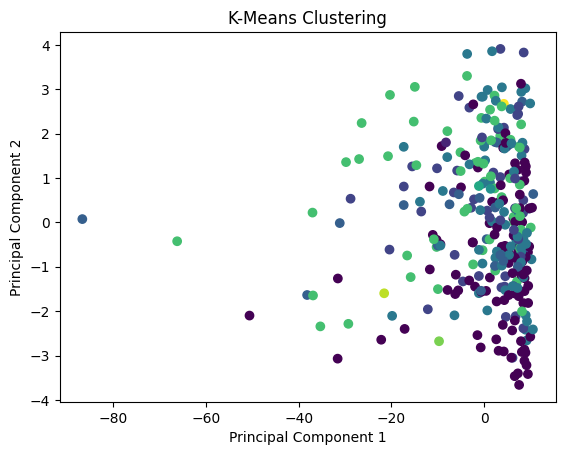

In [ ]:
#visual using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(olmstead_encoded)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.show()

Since the data was high-dimensional with over 200 columns, we needed to use PCA to reduce the dimensionality and be able to visualize the clusters that were created with the K-Means Clustering model.

The data points are color-coded based off of their cluster that was assigned by the model. Based off of the visualization, there aren't any disercenible clusters that we can take away from this. There is a lot of overlap, and it seems that there is not any clear separation for any of the clusters.

In [ ]:
#silhoutte score
kmeans_score = silhouette_score(olmstead_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means: {kmeans_score}")

Silhouette Score for K-Means: -0.02542716907147781


The silhouette score indicates that there is very poor clustering performance. Most of the data points were assined to the wrong cluster and there is a lot of overlap that is present in the clusters. This goes along with what we saw in the visualziation that was created with PCA. There is a lot of room for improvement, but likely it will come from utilizing different data or another machine learning algorithm.

In [ ]:
olmstead_encoded.sample(5)

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnutash,water maple,white,white mulberry,white oak,white pine,willow,willow oak,yellow wood,yellowwood
253,68.80,1.0,0.0,0.0,4.0,0.0,0.0,2.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,92.46,1.0,2.0,0.0,2.0,0.0,1.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
85,83.10,3.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
182,99.48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
32,97.14,0.0,0.0,0.0,1.0,0.0,2.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#creating a column 'invasive_species_sum' based on summing columns 2-16
olmstead_encoded['invasive_species_sum'] = olmstead_encoded.iloc[:, 2:17].sum(axis=1)


In [ ]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,water maple,white,white mulberry,white oak,white pine,willow,willow oak,yellow wood,yellowwood,invasive_species_sum
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,19.0
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,11.0
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,7.0
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,18.0
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,7.0


In [ ]:
#splitting the data
X = olmstead_encoded.drop(['invasive_species_sum'], axis=1)
# replacing invasive_species_sum with classifier based on the median
median_invasive_species_sum = olmstead_encoded['invasive_species_sum'].median()
olmstead_encoded['invasive_risk'] = (olmstead_encoded['invasive_species_sum'] >= median_invasive_species_sum).astype(int)
y = olmstead_encoded['invasive_risk']

For our classification model, we are creating a classifier called invasive_risk. It will separate the invasive species sum into a classifier by using the median, with 0 representing an area that is lower risk and 1 representing an area that is higher risk.

In [ ]:
olmstead_encoded['invasive_risk'].value_counts()

,count
invasive_risk,
1,174
0,137


There is an imbalance between the two classes that will be used for classification, therefore we can utilize a class-balancing method such as SMOTE in order to fix this and have a more accurate model.

In [ ]:
# balancing the classes

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# random forest classifier pipeline with SMOTE and passthrough
rfc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(random_state=42, max_depth=11))
])

This random forest classifier pipeline scales the data to ensure that the classifier isn't affected by any bias from the scale of features, imputes missing values with the mean, and then performs the random forest classifier. The max depth of the tree has been limited to 11 as that was found to be the most optimal for the model's accuracy.

In [ ]:
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('rf', RandomForestClassifier(max_depth=11, random_state=42))])

In [ ]:
#evalutating the random forest classifer
y_pred = rfc_pipeline.predict(X_test)

# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        33
           1       0.91      0.84      0.87        37

    accuracy                           0.87        70
   macro avg       0.87      0.87      0.87        70
weighted avg       0.87      0.87      0.87        70



The model performed generally well and outperformed expectations. The overall accuracy was 90%. The biggest concern would be the recall for the positive class, which was at 86%. This means that only 86% of actual positive (riskier stations) were identified. With the information made available to the model, it appears that it is adequate for prediction across both classes.

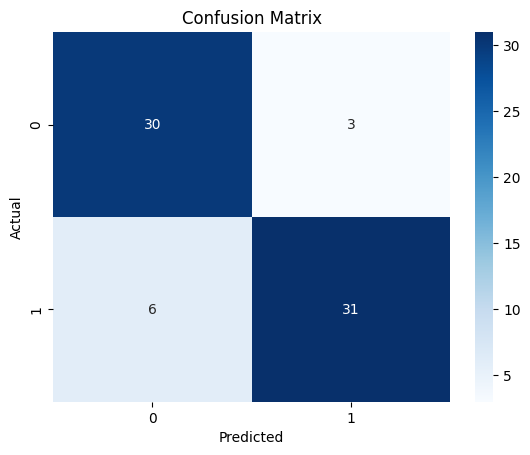

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Random Forest Classifer without Invasive Species Presence

This model will be the same random forest classifier as the previous one, except it will not use the invasive species features as an input. The reason for this is that the invasive species sum is calculated from those invasive species levels, which may be influencing the model to be more accurate than it actually should be.

In [ ]:
#creating a new dataset with olmstead_encoded without columns 2 through 16
olmstead_encoded_new = olmstead_encoded.drop(olmstead_encoded.columns[1:18], axis=1)
# dropping invasive species sum
olmstead_encoded_new = olmstead_encoded_new.drop(['invasive_species_sum'], axis=1)
olmstead_encoded_new.head()

,average_canopy_cover,bass wood,basswood,beech,black gum,black locust,box elder,boxelder,buckeye,butternut hickory,...,water maple,white,white mulberry,white oak,white pine,willow,willow oak,yellow wood,yellowwood,invasive_risk
0,92.98,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,98.18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,97.40,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,87.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# splitting the data
X = olmstead_encoded_new.drop('invasive_risk', axis=1)
y = olmstead_encoded_new['invasive_risk']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# balancing the classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
#fitting the random forest classifier pipeline
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('rf', RandomForestClassifier(max_depth=11, random_state=42))])

In [ ]:
#classification report
y_pred = rfc_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.25      0.30        24
           1       0.62      0.74      0.67        39

    accuracy                           0.56        63
   macro avg       0.50      0.50      0.49        63
weighted avg       0.52      0.56      0.53        63



As expected, there were significant changes in the classification report following the removal of the invasive species columns. The overall accuracy decreased to 56%. The most impacted metric was the recall for the negative class, which decreased from 94% to 24%. An overwhemping majority, 76% of the stations, are predicted as being at risk when they actually aren't. This is very concerning for the model as it would mean that the resources are not being allocated to the areas that they actually should be, if the model was to be used in that use case.

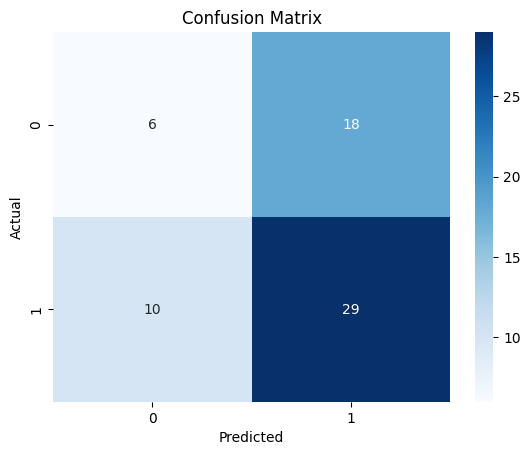

In [ ]:
#confusion matrixz
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Random Forest Regressor

In this random forest regressor model, it will attempt to predict the overall invasiveness of a station (the invasive species sum). As in the previous model, it will not utilize the invasive species columns as they are directly related to the dependent variable.

In [ ]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,white,white mulberry,white oak,white pine,willow,willow oak,yellow wood,yellowwood,invasive_species_sum,invasive_risk
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,19.0,1
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,11.0,1
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,7.0,0
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,18.0,1
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,7.0,0


In [ ]:
#splitting the data from olmstead encoded and dropping columns 1-18
X = olmstead_encoded.drop(olmstead_encoded.columns[1:18], axis=1)
X = X.drop(['invasive_species_sum', 'invasive_risk'], axis=1)
y = olmstead_encoded['invasive_species_sum']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#random forest pipeline
rfr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestRegressor(random_state=42))
])

In [ ]:
#fitting pipeline
rfr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('rf', RandomForestRegressor(random_state=42))])

In [ ]:
# feature importances
importances = rfr_pipeline.named_steps['rf'].feature_importances_
feature_names = rfr_pipeline.named_steps['scaler'].get_feature_names_out()  # or X_train.columns
feature_importances = pd.Series(importances, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances.head(10))

average_canopy_cover    0.245057
elm                     0.073294
maple walnut            0.032461
sycamore                0.031557
maple mulberry          0.029295
beech                   0.028689
tulip poplar            0.027476
hackberry               0.026107
red oak                 0.023314
walnut                  0.022788
dtype: float64


The average canoopy cover is the feature that matters most, and what can be noticed is that there is not much distinction between the importance of the nine features that follow it. This may change further down in the dataset, but there are not any noticable stand outs apart from average canopy coverage.

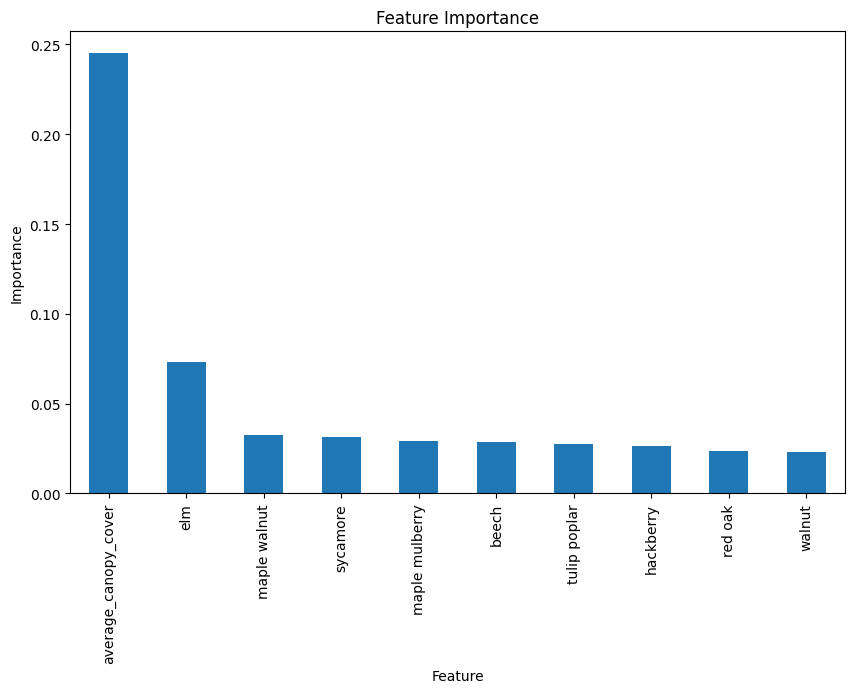

In [ ]:
# creating a bar chart
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance')
plt.show()

In [ ]:
#ypred
y_pred = rfr_pipeline.predict(X_test)

In [ ]:
#evaluating model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 23.754662142243742
R-squared: -0.24356671471147795


The negative r-squared is very concerning for the model. It implies that the regression model is not performant, and does not have any predicitve power. The random forest regression model may not be the best for this data, but with a score this low it is more likely that there is an underlying problem with the relatioinships of the dependent and independent variables. The true variables that are responsible for predicting overall invasivness are likely not present in the data, which is further bringing down the score. At this point, one would likley reevaluate the data as opposed to the model.

In [ ]:
#evaluating for overfitting
train_score = rfr_pipeline.score(X_train, y_train)
test_score = rfr_pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.8631553779526215
Testing Score: -0.24356671471147795


The model did not perfrom terribly on the training data in comparison to the testing data. This implies that overfitting is present in the data. The model does not generalize well to unseen data.